In [ ]:
from   __future__   import absolute_import,division,print_function  
% matplotlib inline  
from   keras.datasets   import   mnist  
from   keras.layers   import Input,Dense,Reshape,Flatten,Dropout,MaxPooling2D,Lambda  
from   keras.layers   import   BatchNormalization,Activation ,ZeroPadding2D
from  keras.layers. advanced_activations import  LeakyReLU  
from   keras.layers.convolutional import UpSampling2D,Conv2D,Conv2DTranspose  
from   keras.models   import   Sequential,Model  
from keras.optimizers import Adam
from keras import initializers
import random 
import matplotlib.pyplot as plt 
import numpy as np

In [ ]:
#GENERATOR ARCHITECTURE

noise_shape = (100,)
img_shape = (28,28,1)

model = Sequential()
model.add(Dense(256, input_shape=noise_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(784, activation='tanh'))
model.add(Reshape(img_shape))

model.summary()

noise = Input(shape=noise_shape)
img = model(noise)

generator =  Model(inputs = noise, outputs = img)

optimizer = Adam(0.0002, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [ ]:
#DISCRIMINATOR

model = Sequential()

model.add(Flatten(input_shape=img_shape))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator =  Model(inputs = img, outputs = validity)
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
____________________________________________

In [ ]:
#COMBINING GENERATOR AND DISCRIMINATOR

z = Input(shape=(100,))
img = generator(z)

# we will only train the generator when we run the combined model
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_1 (Functional)    (None, 32, 32, 3)         3838720   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 1704961   
Total params: 5,543,681
Trainable params: 3,835,136
Non-trainable params: 1,708,545
_________________________________________________________________


In [ ]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap = 'gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

11493376/11490434 [==============================] - 0s 0us/step
0 [D loss: 0.598430, acc.: 58.59%] [G loss: 0.713077]


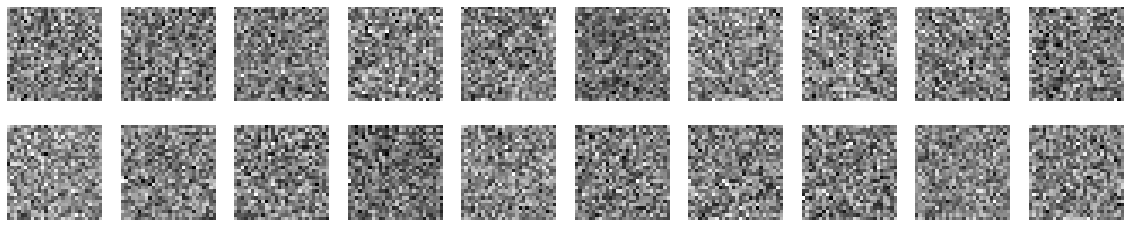

1000 [D loss: 0.603683, acc.: 63.28%] [G loss: 0.876517]


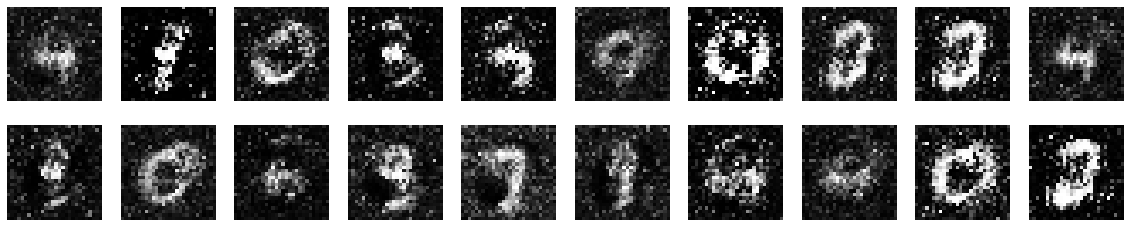

2000 [D loss: 0.603217, acc.: 65.62%] [G loss: 1.073221]


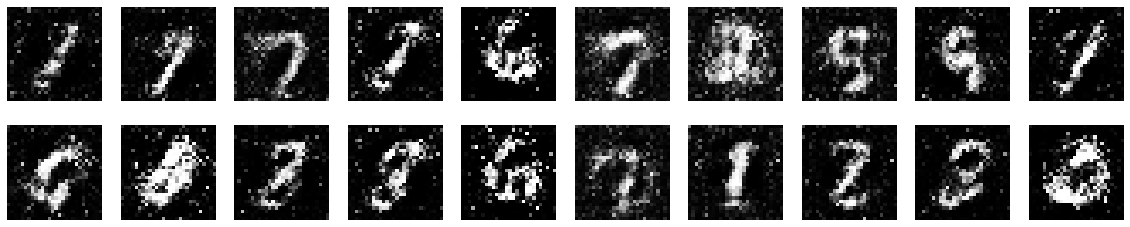

3000 [D loss: 0.562366, acc.: 67.97%] [G loss: 0.958210]


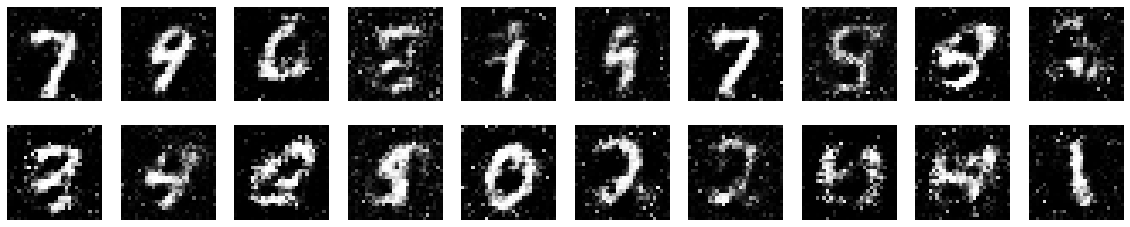

4000 [D loss: 0.648513, acc.: 61.72%] [G loss: 0.852527]


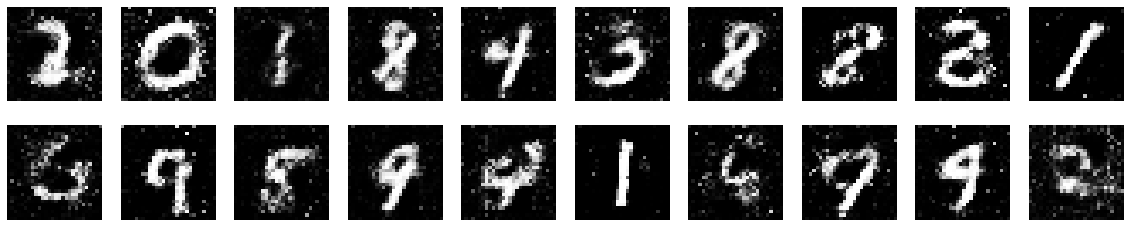

5000 [D loss: 0.708010, acc.: 55.47%] [G loss: 0.878364]


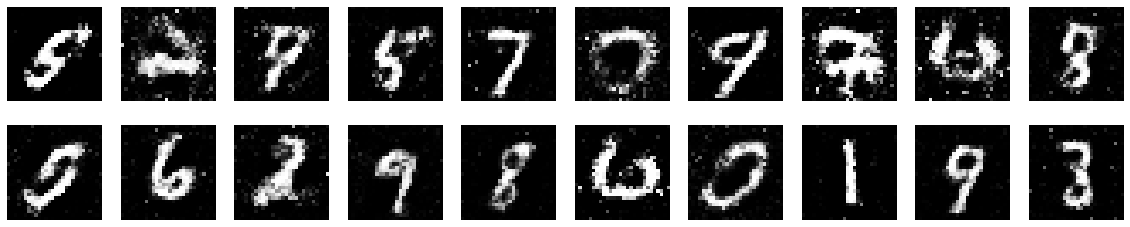

6000 [D loss: 0.691534, acc.: 53.12%] [G loss: 0.862612]


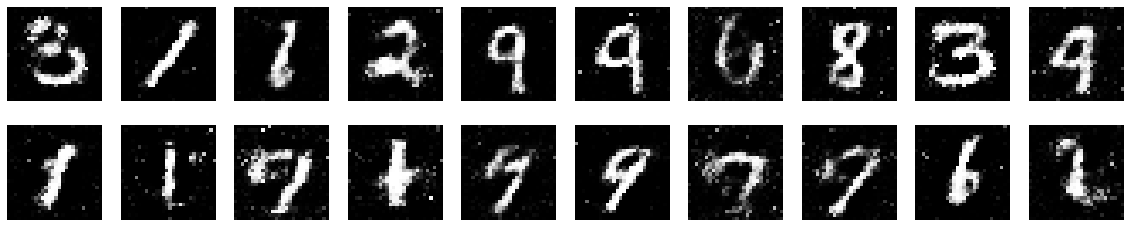

7000 [D loss: 0.689440, acc.: 53.91%] [G loss: 0.864806]


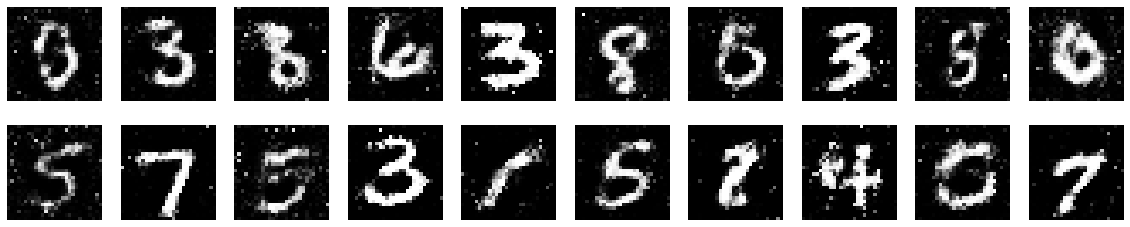

8000 [D loss: 0.695909, acc.: 55.47%] [G loss: 0.816798]


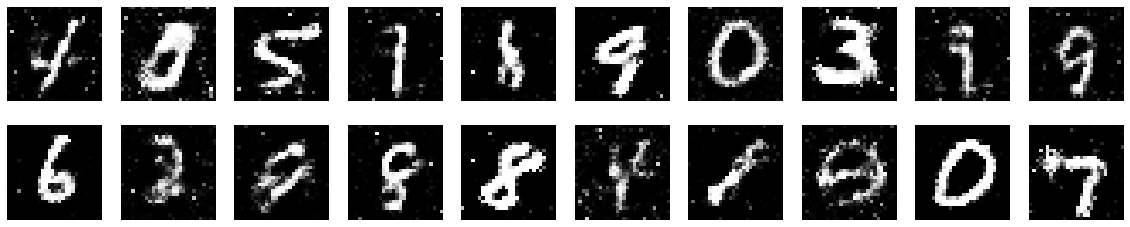

9000 [D loss: 0.721767, acc.: 46.88%] [G loss: 0.826105]


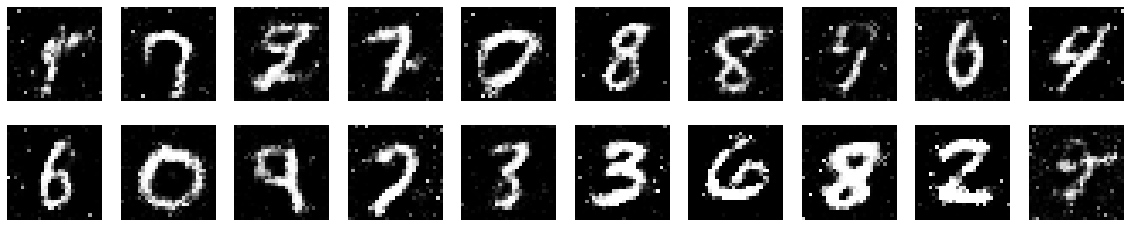

In [ ]:
#TRAINING MODEL USING MNIST DATASET

epochs = 10000
batch_size = 128
print_interval = 1000

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

half_batch = int(batch_size / 2)

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % print_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 
                                                               100*d_loss[1], g_loss))
        print_imgs()

In [ ]:
#USING CIFAR 10 DATASET


from keras.datasets import cifar10

# Load the dataset
(X_train, _), (_, _) = cifar10.load_data()


#Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5


half_batch = int(batch_size / 2)

#Create lists for logging the losses
d_loss_logs_r = []
d_loss_logs_f = []
g_loss_logs = []

noise_shape = (100,)
img_shape = (32,32,3)

In [ ]:
#discriminator

model = Sequential()
model.add(Flatten(input_shape=img_shape))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1, activation='sigmoid'))
model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator =  Model(inputs = img, outputs = validity)
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)              

In [ ]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

#generator
model = Sequential()
model.add(Dense(256, input_shape=noise_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(3072, activation='tanh'))
model.add(Reshape(img_shape))
noise = Input(shape=noise_shape)
img = model(noise)
generator =  Model(inputs = noise, outputs = img)
optimizer = Adam(0.0002, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

epochs = 10000
batch_size = 128
print_interval = 1000

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % print_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 
                                                               100*d_loss[1], g_loss))
        print_imgs()
    
# for cifar10 dataset convolution neural networks are better for generating good images

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#CONVOLUTION GANS TO GENERATE NEW CIFAR10 IMAGES

from keras.datasets import cifar10

# Load the dataset
(X_train, _), (_, _) = cifar10.load_data()


#Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

#Create lists for logging the losses
d_loss_logs_r = []
d_loss_logs_f = []
g_loss_logs = []

noise_shape = (100,)
img_shape = (32,32,3)

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
#generator
noise_shape = (100,)
img_shape = (32,32,3)

model = Sequential()
n_nodes = 256 * 4 * 4
model.add(Dense(n_nodes, input_dim=100))
model.add(LeakyReLU(alpha=0.2))
model.add(Reshape((4, 4, 256)))
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))

model.summary()

noise = Input(shape=noise_shape)
img = model(noise)

generator =  Model(inputs = noise, outputs = img)

optimizer = Adam(0.0002, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

In [ ]:
#discriminator
model = Sequential()
model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

img = Input(shape=img_shape)
validity = model(img)

discriminator =  Model(inputs = img, outputs = validity)
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [ ]:
z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_1 (Functional)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [ ]:
def print_imgs():
    r, c = 2, 10
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c, figsize=(20, 4))
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

0 [D loss: 0.691512, acc.: 37.50%] [G loss: 0.691592]


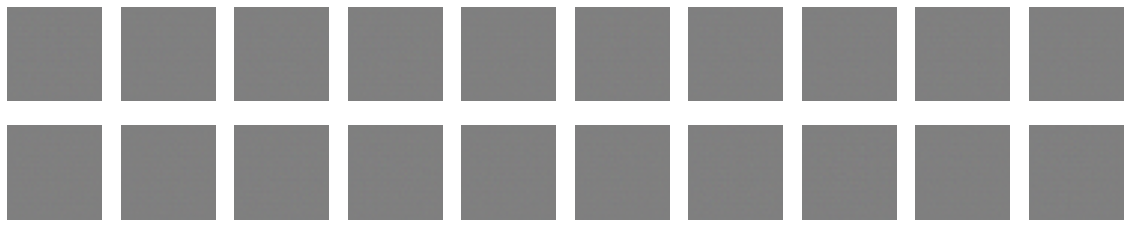

2000 [D loss: 0.725938, acc.: 51.56%] [G loss: 0.783097]


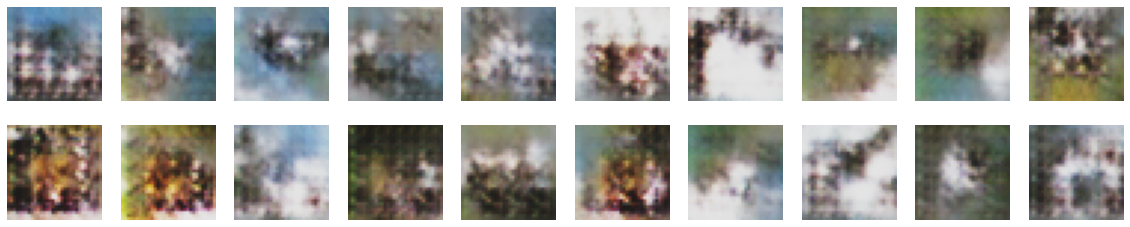

4000 [D loss: 0.641474, acc.: 62.50%] [G loss: 0.863843]


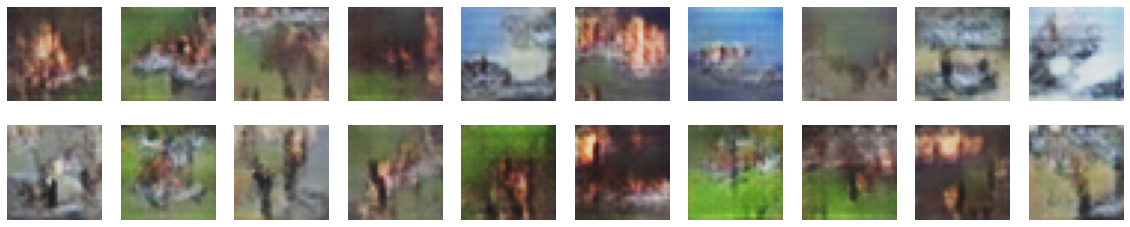

6000 [D loss: 0.670874, acc.: 57.03%] [G loss: 0.765578]


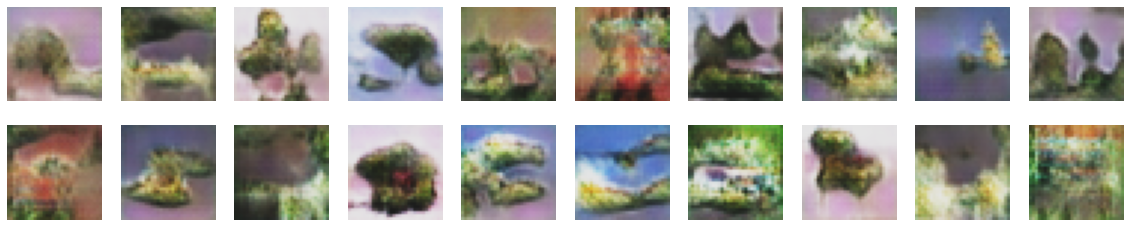

8000 [D loss: 0.668276, acc.: 57.03%] [G loss: 0.874705]


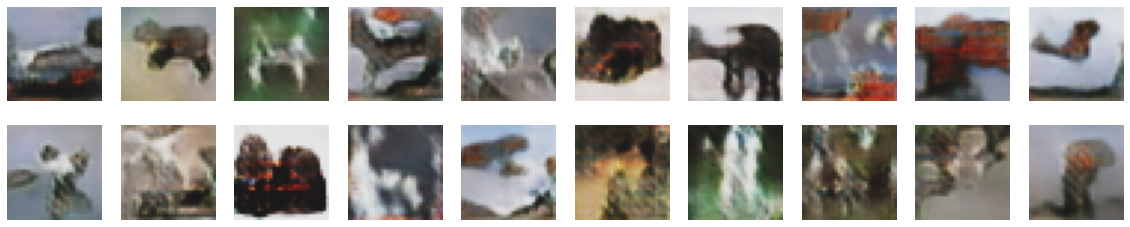

In [ ]:
epochs = 20000
batch_size = 128
print_interval = 2000

half_batch = int(batch_size / 2)

for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    noise = np.random.normal(0, 1, (batch_size, 100))

    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % print_interval == 0:
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 
                                                               100*d_loss[1], g_loss))
        print_imgs()

#some interesting images are obtained even more epochs are required to generate better quality images 